In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
dataset = pd.read_excel("Online Retail.xlsx")
print(f"dataset: {dataset.shape}")


dataset: (541909, 8)


In [3]:
dataset.head()

# invoiceNo:주문 번호/ StockCode: 제품 코드/ Description: 제품 설명
# Quantity: 주문된 제품의 수량/ InvoiceDate: 주문 날짜/ UnitPrice: 제품의 단가
# CustomerID: 고객 식별 번호/ Country: 고객이 속한 국가

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [4]:
dataset.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [5]:
# 주문 고객 국가 영국 데이터만 필터링
dataset = dataset[dataset["Country"] == "United Kingdom"]

In [6]:
dataset.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     133600
Country             0
dtype: int64

## RFM

In [7]:
dataset["TotalPrice"] = dataset["Quantity"] * dataset["UnitPrice"]


# 고객별 데이터 요약 (RFM 변수 생성)
customer_df = dataset.groupby("CustomerID").agg({
    "InvoiceDate": "max",               # Recency
    "InvoiceNo": "nunique",              # Frequency
    "TotalPrice": "sum"                  # Monetary
}).reset_index()



# 변수 이름 변경
customer_df.rename(columns={"InvoiceDate": "Recency", "InvoiceNo": "Frequency", "TotalPrice": "Monetary"}, inplace=True)



# Recency 값 변환: 마지막 구매일로부터의 일수 계산
reference_date = customer_df["Recency"].max()
customer_df["Recency"] = (reference_date - customer_df["Recency"]).dt.days

In [8]:

# 음수가 나올 수가 없음. 음수값 제거
customer_df["Recency"] = np.where(customer_df["Recency"] < 0, np.nan, customer_df["Recency"])

customer_df["Frequency"] = np.where(customer_df["Frequency"] < 0, 0, customer_df["Frequency"])



In [9]:
dataset.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     133600
Country             0
TotalPrice          0
dtype: int64

## 스케일링

In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans


scaler = StandardScaler()
scaled_data = scaler.fit_transform(customer_df[["Recency", "Frequency", "Monetary"]])

In [11]:
#스케일링 전후 비교

# 스케일링된 데이터를 데이터프레임에 추가
scaled_df = pd.DataFrame(scaled_data, columns=["Scaled_Recency", "Scaled_Frequency", "Scaled_Monetary"])

# 원본 데이터와 스케일링된 데이터를 합친 데이터프레임
customer_df_scaled = pd.concat([customer_df, scaled_df], axis=1)

# 결과 출력
print(customer_df_scaled.head())

   CustomerID  Recency  Frequency  Monetary  Scaled_Recency  Scaled_Frequency  \
0     12346.0    325.0          2      0.00        2.337128         -0.347294   
1     12747.0      1.0         11   4196.01       -0.895835          0.685265   
2     12748.0      0.0        224  29072.10       -0.905813         25.122514   
3     12749.0      3.0          8   3868.20       -0.875878          0.341079   
4     12820.0      2.0          4    942.34       -0.885857         -0.117837   

   Scaled_Monetary  
0        -0.261674  
1         0.379155  
2         4.178320  
3         0.329091  
4        -0.117757  


In [16]:
from sklearn.cluster import KMeans

# KMeans 클러스터링 수행 (클러스터 수 3)
kmeans = KMeans(n_clusters=3, random_state=42)
scaled_df['Cluster'] = kmeans.fit_predict(scaled_df[["Scaled_Recency", "Scaled_Frequency", "Scaled_Monetary"]])



## PCA

In [17]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_data = pca.fit_transform(scaled_df)

print("PCA 결과:")
print(pca_data)

PCA 결과:
[[-1.60225325  1.87929329]
 [ 1.12038344 -0.44333228]
 [19.07941354  7.11160281]
 ...
 [ 0.15121871 -0.90813173]
 [ 1.2879434  -0.43202172]
 [ 0.13981577 -0.51262526]]


In [18]:
from sklearn.metrics import silhouette_score
sil_score = silhouette_score(pca_data, kmeans.labels_)
print(f"Silhouette Score: {sil_score}")

Silhouette Score: 0.6555613320472979


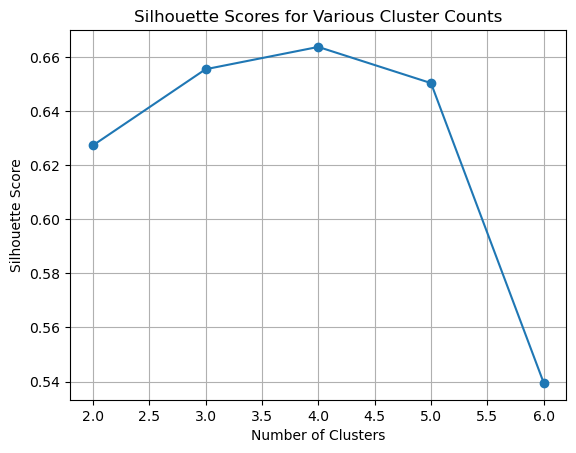

In [19]:
from sklearn.metrics import silhouette_score

def visualize_silhouette(cluster_range, data):
    # 클러스터 수에 대한 실루엣 점수 계산
    silhouette_scores = []
    
    for n_clusters in cluster_range:
        # KMeans 클러스터링 수행
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        cluster_labels = kmeans.fit_predict(data)
        
        # 실루엣 점수 계산
        score = silhouette_score(data, cluster_labels)
        silhouette_scores.append(score)
    
    # 실루엣 점수 시각화
    plt.plot(cluster_range, silhouette_scores, marker='o')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Scores for Various Cluster Counts')
    plt.grid(True)
    plt.show()

# 실루엣 점수를 시각화할 클러스터 수 범위 설정
cluster_range = [2, 3, 4, 5, 6]

# PCA 변환된 데이터를 visualize_silhouette 함수에 전달하여 실루엣 점수 확인
visualize_silhouette(cluster_range, pca_data)

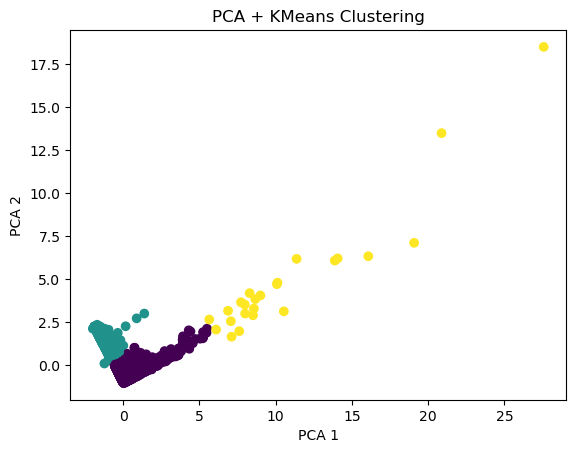

In [20]:
# K-Means 클러스터링
kmeans = KMeans(n_clusters=3, random_state=42)  # 클러스터 수는 3으로 설정
clusters = kmeans.fit_predict(pca_data)

# 결과 시각화
plt.scatter(pca_data[:, 0], pca_data[:, 1], c=clusters, cmap='viridis')
plt.title('PCA + KMeans Clustering')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()